In [1]:
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # オーバーフロー対策
    return np.exp(x) / np.sum(np.exp(x))

In [2]:
class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = 1 / (1 + np.exp(-x))  
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        return dx

In [3]:
class Affine:
    def __init__(self, W, b):
        self.W =W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        # 重み・バイアスパラメータの微分
        self.dW = None
        self.db = None

    def forward(self, x):
        # テンソル対応
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        dx = dx.reshape(*self.original_x_shape)  # 入力データの形状に戻す（テンソル対応）
        return dx

In [4]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [5]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None # softmaxの出力
        self.t = None # 教師データ

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss
    
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 教師データがone-hot-vectorの場合
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
        return dx

In [6]:
class Network:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size) 
        self.params['b2'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Sigmid1'] = Sigmoid()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Sigmid2'] = Sigmoid()

        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
        
    # x:入力データ, t:教師データ
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x:入力データ, t:教師データ
    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads

In [14]:
import sys, os
sys.path.append(os.pardir)
import chainer
import numpy as np
from collections import OrderedDict


train, test = chainer.datasets.get_mnist() #?
x_train, t_train = train._datasets
#print('train:', x_train.shape, t_train.shape)
x_test, t_test = test._datasets
#print('test', x_test.shape, t_test.shape)
t_train=np.eye(10)[t_train]
t_test=np.eye(10)[t_test]

# データの読み込み
#(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = Network(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_loss_list2 = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 勾配
    grad = network.gradient(x_batch, t_batch)
    
    # 更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_loss_list2.append(loss)
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc|" + str(train_acc) + ", " + str(test_acc))

print('end')



train acc, test acc|0.09736666666666667, 0.0982
train acc, test acc|0.11236666666666667, 0.1135
train acc, test acc|0.4874833333333333, 0.4906
train acc, test acc|0.65945, 0.6672
train acc, test acc|0.7403333333333333, 0.7471
train acc, test acc|0.76135, 0.7622
train acc, test acc|0.7615833333333333, 0.7632
train acc, test acc|0.7857666666666666, 0.7874
train acc, test acc|0.8033, 0.8057
train acc, test acc|0.81265, 0.8191
train acc, test acc|0.8250833333333333, 0.8313
train acc, test acc|0.8281, 0.8334
train acc, test acc|0.833, 0.8379
train acc, test acc|0.83815, 0.8443
train acc, test acc|0.84115, 0.8483
train acc, test acc|0.8436333333333333, 0.8493
train acc, test acc|0.8473166666666667, 0.853
end


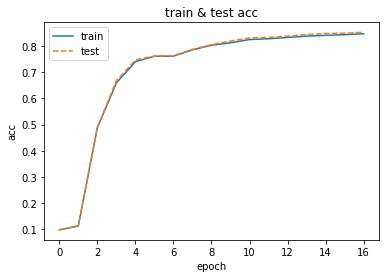

In [15]:
import matplotlib.pyplot as plt

plt.plot(train_acc_list, label="train") 
plt.plot(test_acc_list, linestyle="--", label="test") 
plt.xlabel("epoch") 
plt.ylabel("acc")
plt.title('train & test acc')

plt.legend()

plt.show()

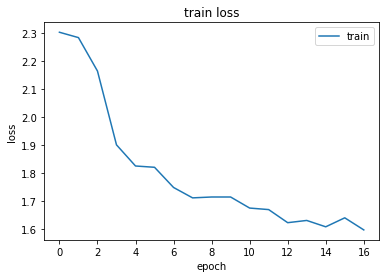

In [17]:
plt.plot(train_loss_list2, label="train") 
plt.xlabel("epoch") 
plt.ylabel("loss")
plt.title('train loss')

plt.legend()

plt.show()